In [1]:
# path of dataset file
import os
dataset = "D:/Working papers/Colon Diesease/Datasets/EndoTech/EndoTect/IMG/"
print(os.listdir(dataset))


['adenomatous', 'hyperplastic']


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

import numpy as np

from deap import base, creator, tools, algorithms
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, hinge_loss
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# Load the pretrained EfficientNet model
efficientnet = models.efficientnet_b0(pretrained=True)

# Remove the final classification layer to use the model for feature extraction
efficientnet = nn.Sequential(*list(efficientnet.children())[:-1])

# Set the model to evaluation mode
efficientnet.eval()

# Define a transform to preprocess the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def extract_features(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    return features.squeeze().numpy()

D:\Implementation\ColonCancer\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Implementation\ColonCancer\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
classes = os.listdir(dataset)
# Extract features and labels
features_list = []
labels_list = []

for label, class_dir in enumerate(classes):
    class_path = os.path.join(dataset, class_dir)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        features = extract_features(image_path, efficientnet)
        features_list.append(features)
        labels_list.append(label)


features = np.vstack(features_list)
labels = np.hstack(labels_list)

print(f'Features shape: {features.shape}')
print(f'Features shape: {features.shape}')

print(f'Features shape: {features.shape}')
print(f'Number of features extracted per image: {features.shape[1]}')


Features shape: (1200, 1280)
Features shape: (1200, 1280)
Features shape: (1200, 1280)
Number of features extracted per image: 1280


In [5]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import joblib
import multiprocessing



In [6]:
# Initialize lists to store accuracy and loss
train_accuracy_svm_list = []
validation_accuracy_svm_list = []
train_loss_svm_list = []
validation_loss_svm_list = []
selected_feature_counts = []  # List to store feature counts after selection

class FeatureSelectionProblem(Problem):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        super().__init__(n_var=features.shape[1], n_obj=1, xl=0, xu=1, type_var=np.bool_)

    def _evaluate(self, x, out, *args, **kwargs):
        res = []
        for individual in x:
            selected_features = np.where(individual)[0]
             # Count and store the number of selected features for each individual
            selected_feature_counts.append(len(selected_features))
            
            if len(selected_features) == 0:
                res.append([0])  # Invalid solution
                continue
            X_train, X_test, y_train, y_test = train_test_split(self.features[:, selected_features], self.labels, test_size=0.3, random_state=42)

            # SVM
            svm = SVC(kernel='poly')
            svm.fit(X_train, y_train)

            # Calculate training accuracy
            y_train_pred = svm.predict(X_train)
            train_accuracy_svm = accuracy_score(y_train, y_train_pred)
            train_accuracy_svm_list.append(train_accuracy_svm * 100)
            #print(f"Train Accuracy SVM: {train_accuracy_svm * 100:.2f}%") 

            # Calculate validation accuracy
            y_test_pred = svm.predict(X_test)
            validation_accuracy_svm = accuracy_score(y_test, y_test_pred)
            validation_accuracy_svm_list.append(validation_accuracy_svm * 100)
            #print(f"Validation Accuracy SVM: {validation_accuracy_svm * 100:.2f}%")

            # Calculate training and validation loss
            train_loss_svm = hinge_loss(y_train, svm.decision_function(X_train))
            validation_loss_svm = hinge_loss(y_test, svm.decision_function(X_test))
            train_loss_svm_list.append(train_loss_svm)
            validation_loss_svm_list.append(validation_loss_svm)
            #print(f"Train Loss SVM: {train_loss_svm * 100:.2f}")
            #print(f"Validation Loss SVM: {validation_loss_svm * 100:.2f}")

            res.append([1 - validation_accuracy_svm])

        out['F'] = np.array(res)

In [7]:

problem = FeatureSelectionProblem(features, labels)



In [8]:
# Parallel processing setup
pool = multiprocessing.Pool()
toolbox = base.Toolbox()
toolbox.register("map", pool.map)


In [9]:
algorithm = NSGA2(pop_size=25,
                  sampling=BinaryRandomSampling(),
                  crossover=TwoPointCrossover(),
                  mutation=BitflipMutation(),
                  eliminate_duplicates=True)


In [10]:

res = minimize(problem,
               algorithm,
               ('n_gen', 25),
               seed=1,
               save_history=True,
               verbose=True,
                eliminate_duplicates=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       25 |      1 |             - |             -
     2 |       50 |      1 |  0.0055555556 |         ideal
     3 |       75 |      1 |  0.0055555556 |         ideal
     4 |      100 |      1 |  0.0027777778 |         ideal
     5 |      125 |      2 |  0.000000E+00 |             f
     6 |      150 |      1 |  0.0027777778 |         ideal
     7 |      175 |      1 |  0.000000E+00 |             f
     8 |      200 |      2 |  0.000000E+00 |             f
     9 |      225 |      2 |  0.0027777778 |         ideal
    10 |      250 |      2 |  0.000000E+00 |             f
    11 |      275 |      1 |  0.0055555556 |         ideal
    12 |      300 |      2 |  0.000000E+00 |             f
    13 |      325 |      4 |  0.000000E+00 |             f
    14 |      350 |      7 |  0.000000E+00 |             f
    15 |      375 |     12 |  0.000000E+00 |             f
    16 |      400 |      2 |  0.0027777778 |         ide

In [11]:
# After optimization, print the feature counts
print("Selected feature counts after NSGA-II for each solution:")
for i, count in enumerate(selected_feature_counts, start=1):
    print(f"Solution {i}: {count} features selected")

Selected feature counts after NSGA-II for each solution:
Solution 1: 635 features selected
Solution 2: 625 features selected
Solution 3: 646 features selected
Solution 4: 637 features selected
Solution 5: 596 features selected
Solution 6: 689 features selected
Solution 7: 654 features selected
Solution 8: 622 features selected
Solution 9: 633 features selected
Solution 10: 636 features selected
Solution 11: 610 features selected
Solution 12: 629 features selected
Solution 13: 653 features selected
Solution 14: 621 features selected
Solution 15: 608 features selected
Solution 16: 640 features selected
Solution 17: 633 features selected
Solution 18: 639 features selected
Solution 19: 650 features selected
Solution 20: 639 features selected
Solution 21: 680 features selected
Solution 22: 653 features selected
Solution 23: 646 features selected
Solution 24: 614 features selected
Solution 25: 655 features selected
Solution 26: 609 features selected
Solution 27: 638 features selected
Solutio

In [12]:
# Print selected feature counts per image
print("Number of selected features for each image after NSGA-II:")
for i, count in enumerate(selected_feature_counts, start=1):
    print(f"Image {i}: {count} features selected")

Number of selected features for each image after NSGA-II:
Image 1: 635 features selected
Image 2: 625 features selected
Image 3: 646 features selected
Image 4: 637 features selected
Image 5: 596 features selected
Image 6: 689 features selected
Image 7: 654 features selected
Image 8: 622 features selected
Image 9: 633 features selected
Image 10: 636 features selected
Image 11: 610 features selected
Image 12: 629 features selected
Image 13: 653 features selected
Image 14: 621 features selected
Image 15: 608 features selected
Image 16: 640 features selected
Image 17: 633 features selected
Image 18: 639 features selected
Image 19: 650 features selected
Image 20: 639 features selected
Image 21: 680 features selected
Image 22: 653 features selected
Image 23: 646 features selected
Image 24: 614 features selected
Image 25: 655 features selected
Image 26: 609 features selected
Image 27: 638 features selected
Image 28: 606 features selected
Image 29: 627 features selected
Image 30: 630 features 

In [13]:
# Print the results as a table
from tabulate import tabulate
table = [
    [i+1, train_accuracy, val_accuracy, train_loss, val_loss]
    for i, (train_accuracy, val_accuracy, train_loss, val_loss) 
    in enumerate(zip(train_accuracy_svm_list, validation_accuracy_svm_list, train_loss_svm_list, validation_loss_svm_list))
]
headers = ["Iteration", "Training Accuracy (%)", "Validation Accuracy (%)", "Training Loss", "Validation Loss"]
print(tabulate(table, headers=headers, tablefmt="grid"))

+-------------+-------------------------+---------------------------+-----------------+-------------------+
|   Iteration |   Training Accuracy (%) |   Validation Accuracy (%) |   Training Loss |   Validation Loss |
+=============+=========================+===========================+=================+===================+
|           1 |                 97.5    |                   86.6667 |        0.114839 |          0.333961 |
+-------------+-------------------------+---------------------------+-----------------+-------------------+
|           2 |                 97.1429 |                   86.9444 |        0.120346 |          0.328678 |
+-------------+-------------------------+---------------------------+-----------------+-------------------+
|           3 |                 97.0238 |                   86.6667 |        0.114226 |          0.336845 |
+-------------+-------------------------+---------------------------+-----------------+-------------------+
|           4 |             

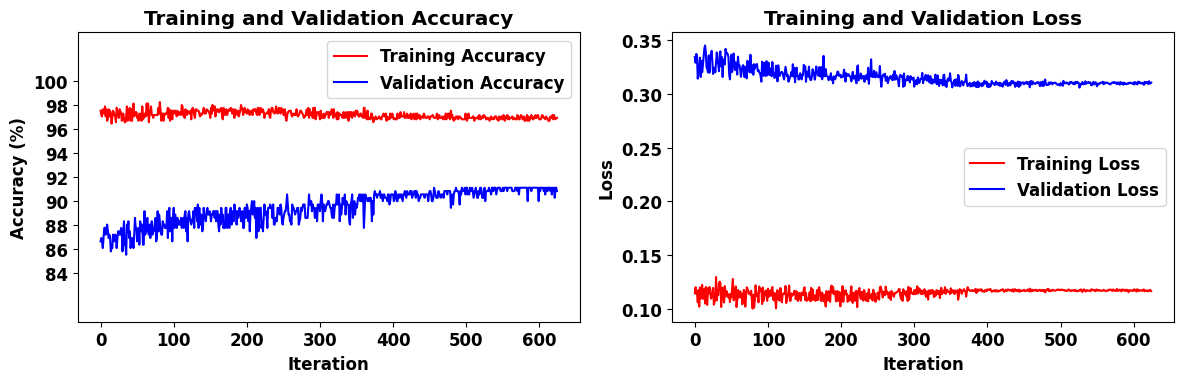

In [14]:
import matplotlib.pyplot as plt

# Set font size and weight for all text in the plot
plt.rcParams.update({
    'font.size': 12,      # Font size
    'font.weight': 'bold' # Font weight
})

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_svm_list, label='Training Accuracy', color='red')
plt.plot(validation_accuracy_svm_list, label='Validation Accuracy', color='blue')
plt.ylim(80, 104)  # Set y-axis range from 80 to 100
plt.yticks(np.arange(84, 102, 2))  # Step size of 2 for y-axis ticks
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Training and Validation Accuracy', fontweight='bold')
plt.legend()
#plt.yticks(range(70, len(train_accuracy_svm_list) + 1, 20))  # Set x-axis ticks with step size of 20

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
#plt.figure(figsize=(12, 5))
plt.plot(train_loss_svm_list, label='Training Loss', color='red')
plt.plot(validation_loss_svm_list, label='Validation Loss', color='blue')
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.title('Training and Validation Loss', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()



In [15]:
# Extract the best individual solution from NSGA-II results
best_individuals = res.X
best_individual = np.atleast_1d(best_individuals[0])  # Convert to at least 1-dimensional array if scalar

# Find indices of selected features
selected_features = np.where(best_individual)[0]
print(f'Selected Features: {selected_features}')

Selected Features: [   1    3    4    5    6    9   12   15   16   26   27   28   33   36
   38   43   46   47   50   51   57   58   61   65   69   70   71   73
   74   75   77   78   81   82   84   85   86   87   88   92   96   99
  100  101  103  104  106  107  111  113  114  117  119  121  122  124
  125  129  132  133  134  135  137  138  142  144  147  148  149  150
  152  154  155  157  158  159  163  164  165  166  167  169  170  172
  173  175  177  179  180  184  185  186  188  191  192  194  195  197
  198  201  204  205  207  210  211  212  215  216  219  220  221  222
  223  225  228  229  230  231  236  238  239  240  243  244  246  248
  249  252  259  268  269  273  276  279  280  281  289  291  292  297
  301  302  305  306  310  311  313  315  316  317  319  321  322  323
  325  326  328  329  335  336  337  338  340  344  345  346  347  355
  356  357  359  361  362  364  366  370  371  374  377  379  380  383
  384  386  387  389  394  395  397  399  402  403  405  4

In [16]:
# Select features based on NSGA-II results
X_selected = features[:, selected_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, labels_list, test_size=0.3, random_state=42)



SVM Accuracy: 0.9111
SVM Precision: 0.9185
SVM Recall: 0.8552
SVM F1 Score: 0.8857
SVM AUC: 0.9570


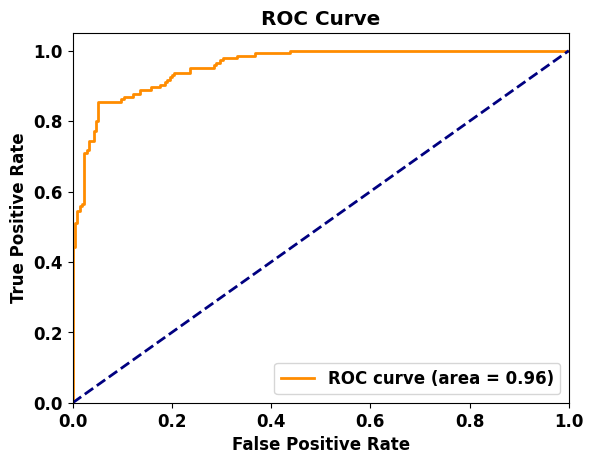

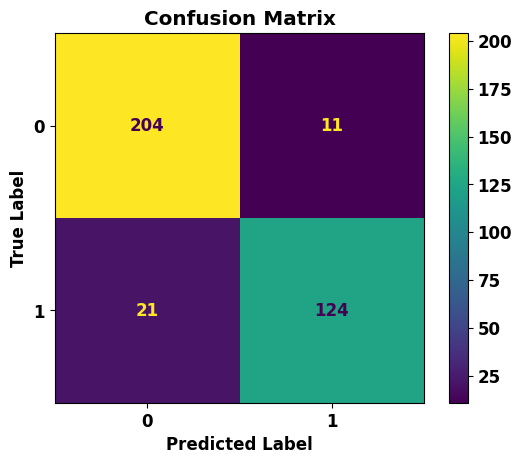

In [17]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.ylabel('True Positive Rate', fontweight='bold')
    plt.title(title, fontweight='bold')
    plt.legend(loc="lower right")
    plt.show()

# Train and evaluate SVM
svm = SVC(kernel='poly', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_score_svm = svm.decision_function(X_test)

# Compute metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

print(f'SVM Accuracy: {accuracy_svm:.4f}')
print(f'SVM Precision: {precision_svm:.4f}')
print(f'SVM Recall: {recall_svm:.4f}')
print(f'SVM F1 Score: {f1_svm:.4f}')
print(f'SVM AUC: {roc_auc_svm:.4f}')

# Plot ROC curve for SVM
plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, 'ROC Curve')

# Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title('Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.show()

In [18]:

# Don't forget to close the pool when you're done
pool.close()
pool.join()